In [1]:
from tqdm import tqdm
import requests
import pandas as pd
import numpy as np
import os

from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/home/milosevicn/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
2023-01-29 16:31:34.327535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
assays = [
    "ATG_PPARg_TRANS_dn", 
    "ATG_PPARg_TRANS_up", 
    "TOX21_PPARg_BLA_antagonist_ratio", 
    "TOX21_PPARg_BLA_Agonist_ratio", 
    "NVS_NR_hPPARg", 
    "ERF_ENZ_hCYP19A1_dn", 
    "NVS_ADME_hCYP19A1", 
    "NVS_ADME_hCYP19A1_Activator", 
    "TOX21_Aromatase_Inhibition", 
    "CEETOX_H295R_ESTRADIOL_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_up", 
    "CEETOX_H295R_ESTRADIOL_up", 
    "CEETOX_H295R_ESTRONE_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_up", 
    "CEETOX_H295R_ESTRONE_up"
]

In [3]:
test_data = [
    "inference_results/sac/Chemical List EDSP21LIST2-2021-12-28.csv",
    "inference_results/sac/Chemical List EDSPUOC-2022-06-16.csv",
    "inference_results/sac/Chemical List OSHA-2021-12-28.csv",
    "inference_results/sac/Chemical List UBAPMT-2021-12-28.csv",
    "inference_results/sac/Chemical List EDSP21LIST1-2021-12-28.csv"    
]

In [5]:
def inference(row, model, model_name):
    try:
        smiles = str(row["smiles"])
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2) # TODO: can replace morgan with other fingerprint!
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        # conv:
        arr = arr.reshape(-1, 2048, 1)
        out = model.predict(arr).round()[0]
        row[model_name] = int(out)
        
    except Exception as e:
        # print(e)
        print("Bad smiles string? For:", row["PREFERRED NAME"])
        
    return row

In [ ]:
os.system("cp data_tests/*.csv inference_results/sac/")

In [ ]:
for assay in assays:
    model = keras.models.load_model(f"models/sac/nn_{assay}.h5")

    for test in test_data:    
        df = pd.read_csv(test)
        df[assay] = "unknown"

        df = df.apply(lambda x: inference(x, model, assay), axis=1)

        df.to_csv(test, index=False)

In [4]:
dfs = []

for f in test_data:
    df = pd.read_csv(f.replace("data_tests/", "inference_results/sac/"))
    df["Database"] = f.split("/")[-1].replace(".csv", "").replace("Chemical List ", "")
    df["Use category"] = ""
    df = df[["casrn", "PREFERRED NAME", "Database", "Use category", *assays, "# ToxCast Active"]]
    
    df["ke1"] = "unknown"
    df["ke2"] = "unknown"
    df["ke3"] = "unknown"
    
    def process(row, ke, up_assays, dn_assays):        
        
        unk = any([str(row[a]) == "unknown" for a in dn_assays + up_assays])
        if unk:
            return row        
        
        dn = any([str(row[a]) == "1" for a in dn_assays])
        up = any([str(row[a]) == "1" for a in up_assays])
        
        if dn and not up:
            row[ke] = "Down"
        elif not dn and up:
            row[ke] = "Up"
        elif dn and up:
            row[ke] = "Up/Down"
        elif not dn and not up:
            row[ke] = "NA"

        return row
    
    df = df.apply(lambda row: process(row, "ke1", 
                                      ["ATG_PPARg_TRANS_up", "TOX21_PPARg_BLA_Agonist_ratio"], 
                                      ["ATG_PPARg_TRANS_dn", "TOX21_PPARg_BLA_antagonist_ratio", "NVS_NR_hPPARg"]), 
                  axis=1)
    
    df = df.apply(lambda row: process(row, "ke2", 
                                      ["NVS_ADME_hCYP19A1_Activator"], 
                                      ["ERF_ENZ_hCYP19A1_dn", "NVS_ADME_hCYP19A1", "TOX21_Aromatase_Inhibition"]), 
                  axis=1)
    
    df = df.apply(lambda row: process(row, "ke3", 
                                      ["CEETOX_H295R_ESTRADIOL_noMTC_up", "CEETOX_H295R_ESTRADIOL_up", # "CEETOX_H295R_ESTRONE_noMTC_up", "CEETOX_H295R_ESTRONE_up"
                                      ], 
                                      ["CEETOX_H295R_ESTRADIOL_dn", "CEETOX_H295R_ESTRADIOL_noMTC_dn", # "CEETOX_H295R_ESTRONE_dn", "CEETOX_H295R_ESTRONE_noMTC_dn"
                                      ]), 
                  axis=1)
        
    dfs.append(df)

In [5]:
dfs[0]

,casrn,PREFERRED NAME,Database,Use category,ATG_PPARg_TRANS_dn,ATG_PPARg_TRANS_up,TOX21_PPARg_BLA_antagonist_ratio,TOX21_PPARg_BLA_Agonist_ratio,NVS_NR_hPPARg,ERF_ENZ_hCYP19A1_dn,...,CEETOX_H295R_ESTRADIOL_noMTC_up,CEETOX_H295R_ESTRADIOL_up,CEETOX_H295R_ESTRONE_dn,CEETOX_H295R_ESTRONE_noMTC_dn,CEETOX_H295R_ESTRONE_noMTC_up,CEETOX_H295R_ESTRONE_up,# ToxCast Active,ke1,ke2,ke3
0,1336-36-3,Polychlorinated biphenyls,EDSP21LIST2-2021-12-28,,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,,unknown,unknown,unknown
1,77182-82-2,Glufosinate-ammonium,EDSP21LIST2-2021-12-28,,0,0,0,0,0,1,...,1,0,0,1,0,1,,NA,Down,Up/Down
2,55-63-0,Trinitroglycerin,EDSP21LIST2-2021-12-28,,0,0,0,0,0,1,...,1,0,1,1,0,1,,NA,Down,Up/Down
3,14797-73-0,Perchlorate,EDSP21LIST2-2021-12-28,,0,0,0,0,1,1,...,1,0,0,1,0,1,,Down,Down,Up/Down
4,121-82-4,Cyclonite,EDSP21LIST2-2021-12-28,,0,0,0,0,0,1,...,1,0,0,1,0,1,,NA,Down,Up/Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,101-77-9,"4,4'-Diaminobiphenyl methane",EDSP21LIST2-2021-12-28,,0,1,0,0,1,1,...,1,0,1,1,0,1,51/884,Up/Down,Down,Up/Down
102,81777-89-1,Clomazone,EDSP21LIST2-2021-12-28,,0,0,0,0,0,1,...,1,0,0,1,0,1,64/950,NA,Down,Up/Down
103,80844-07-1,Etofenprox,EDSP21LIST2-2021-12-28,,0,0,0,0,0,1,...,1,0,1,1,0,1,68/917,NA,Down,Up/Down
104,74115-24-5,Clofentezine,EDSP21LIST2-2021-12-28,,0,1,0,0,0,1,...,0,1,0,1,0,1,71/936,Up,Down,Up/Down


In [6]:
full = pd.concat(dfs)
# for a in assays:
#     del full[a]

full.to_csv("inference_results/sac_single_table.csv", index=False)

In [8]:
df = pd.read_csv("inference_results/sac_single_table.csv", converters = {'ke1': str, 'ke2': str, 'ke3': str})
df

,casrn,PREFERRED NAME,Database,Use category,ATG_PPARg_TRANS_dn,ATG_PPARg_TRANS_up,TOX21_PPARg_BLA_antagonist_ratio,TOX21_PPARg_BLA_Agonist_ratio,NVS_NR_hPPARg,ERF_ENZ_hCYP19A1_dn,...,CEETOX_H295R_ESTRADIOL_noMTC_up,CEETOX_H295R_ESTRADIOL_up,CEETOX_H295R_ESTRONE_dn,CEETOX_H295R_ESTRONE_noMTC_dn,CEETOX_H295R_ESTRONE_noMTC_up,CEETOX_H295R_ESTRONE_up,# ToxCast Active,ke1,ke2,ke3
0,1336-36-3,Polychlorinated biphenyls,EDSP21LIST2-2021-12-28,NaN,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,,unknown,unknown,unknown
1,77182-82-2,Glufosinate-ammonium,EDSP21LIST2-2021-12-28,NaN,0,0,0,0,0,1,...,1,0,0,1,0,1,,NA,Down,Up/Down
2,55-63-0,Trinitroglycerin,EDSP21LIST2-2021-12-28,NaN,0,0,0,0,0,1,...,1,0,1,1,0,1,,NA,Down,Up/Down
3,14797-73-0,Perchlorate,EDSP21LIST2-2021-12-28,NaN,0,0,0,0,1,1,...,1,0,0,1,0,1,,Down,Down,Up/Down
4,121-82-4,Cyclonite,EDSP21LIST2-2021-12-28,NaN,0,0,0,0,0,1,...,1,0,0,1,0,1,,NA,Down,Up/Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9713,84-66-2,Diethyl phthalate,EDSP21LIST1-2021-12-28,NaN,0,0,0,0,1,1,...,1,0,0,0,0,1,11/880,Down,Down,Up
9714,108-88-3,Toluene,EDSP21LIST1-2021-12-28,NaN,0,0,0,0,1,1,...,1,0,0,1,0,1,0/235,Down,Down,Up/Down
9715,1071-83-6,Glyphosate,EDSP21LIST1-2021-12-28,NaN,0,0,0,0,1,1,...,1,0,0,1,0,1,0/52,Down,Down,Up/Down
9716,67-64-1,Acetone,EDSP21LIST1-2021-12-28,NaN,0,0,0,0,1,1,...,1,0,0,1,0,1,1/235,Down,Down,Up/Down


In [10]:
df = df.drop_duplicates(subset=['casrn'])

In [11]:
df[["ke1", "ke2", "ke3"]].value_counts()

ke1      ke2      ke3    
Down     Down     Up/Down    3150
NA       Down     Up/Down    2388
Up/Down  Down     Up/Down    1479
Up       Down     Up/Down     849
Down     Down     Down        187
Up/Down  Down     Down        110
NA       Down     Down        100
Up/Down  Down     Up           75
NA       Down     Up           75
Down     Down     Up           59
unknown  unknown  unknown      52
Up       Down     Up           36
                  Down         28
NA       Up/Down  Up/Down      20
Down     Up/Down  Up/Down      11
NA       Up/Down  Up            4
Up       Up/Down  Up/Down       3
Down     Up/Down  Up            2
Up/Down  Up/Down  Up/Down       1
dtype: int64

In [12]:
counts = df[(df["ke1"] != "unknown") | (df["ke2"] != "unknown") | (df["ke3"] != "unknown")][["ke1", "ke2", "ke3"]].value_counts()

In [13]:
counts = pd.DataFrame(counts)
counts

,,,0
ke1,ke2,ke3,
Down,Down,Up/Down,3150
NA,Down,Up/Down,2388
Up/Down,Down,Up/Down,1479
Up,Down,Up/Down,849
Down,Down,Down,187
Up/Down,Down,Down,110
NA,Down,Down,100
Up/Down,Down,Up,75
NA,Down,Up,75


In [14]:
counts["test"] = counts.index

In [15]:
def process(row):
    
    t = 3 - row["test"].count("NA")
    row["involved"] = t
    
    return row

counts = counts.apply(process, axis=1)

In [16]:
counts

,,,0,test,involved
ke1,ke2,ke3,,,
Down,Down,Up/Down,3150,"(Down, Down, Up/Down)",3
NA,Down,Up/Down,2388,"(NA, Down, Up/Down)",2
Up/Down,Down,Up/Down,1479,"(Up/Down, Down, Up/Down)",3
Up,Down,Up/Down,849,"(Up, Down, Up/Down)",3
Down,Down,Down,187,"(Down, Down, Down)",3
Up/Down,Down,Down,110,"(Up/Down, Down, Down)",3
NA,Down,Down,100,"(NA, Down, Down)",2
Up/Down,Down,Up,75,"(Up/Down, Down, Up)",3
NA,Down,Up,75,"(NA, Down, Up)",2


,Key Event Involvement,invol
involved,,
2,2587,2
3,5990,3


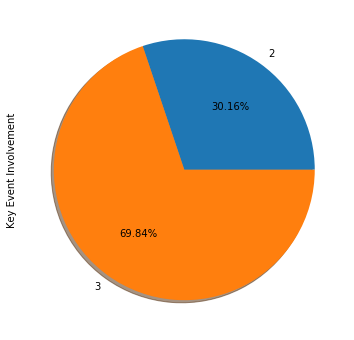

In [31]:
counts = counts.groupby("involved").sum("0")
counts["invol"] = counts.index
counts.columns = ["Key Event Involvement", "invol"]
counts.plot(kind="pie", x="invol", y="Key Event Involvement", legend=False, 
                   autopct='%1.2f%%', explode=(0, 0), 
                   shadow=True, startangle=0, figsize=(10,6))
counts

In [14]:
# Up       Down      Down izvuci
udd = df[(df["ke1"] == "Up") & (df["ke2"] == "Down") & (df["ke3"] == "Down")]

udd.to_csv("inference_results/sac_udd.csv", index=False)

udd

,casrn,PREFERRED NAME,Database,Use category,ATG_PPARg_TRANS_dn,ATG_PPARg_TRANS_up,TOX21_PPARg_BLA_antagonist_ratio,TOX21_PPARg_BLA_Agonist_ratio,NVS_NR_hPPARg,ERF_ENZ_hCYP19A1_dn,...,CEETOX_H295R_ESTRADIOL_noMTC_up,CEETOX_H295R_ESTRADIOL_up,CEETOX_H295R_ESTRONE_dn,CEETOX_H295R_ESTRONE_noMTC_dn,CEETOX_H295R_ESTRONE_noMTC_up,CEETOX_H295R_ESTRONE_up,# ToxCast Active,ke1,ke2,ke3
171,1072-71-5,"2,5-Dimercapto-1,3,4-thiadiazole",EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,1,1,0,1,8/408,Up,Down,Down
1213,3179-80-4,N-[3-(Dimethylamino)propyl]dodecanamide,EDSPUOC-2022-06-16,NaN,0,0,0,1,0,1,...,0,0,0,1,0,1,182/401,Up,Down,Down
1352,74782-23-3,Oxabentrinil,EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,0,1,0,1,,Up,Down,Down
2320,111974-72-2,Quetiapine fumarate,EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,0,1,0,1,43/398,Up,Down,Down
2337,264618-44-2,SSR146977,EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,0,1,0,1,218/981,Up,Down,Down
2408,98319-26-7,Finasteride,EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,1,1,0,1,71/577,Up,Down,Down
2950,887-54-7,Chlorthal-monomethyl,EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,0,1,0,1,,Up,Down,Down
3073,5437-33-2,"3,5-Dichloro-2-pyridone",EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,0,1,0,1,,Up,Down,Down
3276,68583-51-7,"Decanoic acid, mixed diesters with octanoic ac...",EDSPUOC-2022-06-16,NaN,0,1,0,0,0,1,...,0,0,0,1,0,1,,Up,Down,Down
3368,4404-43-7,C.I. Fluorescent brightening agent 28,EDSPUOC-2022-06-16,NaN,0,1,0,1,0,1,...,0,0,0,1,0,1,,Up,Down,Down


In [ ]:
df[["ke1"]].value_counts(), df[["ke2"]].value_counts(), df[["ke3"]].value_counts()

In [ ]:
df[["ke1", "ke2", "ke3"]].value_counts().plot(kind="bar")

In [ ]:
df[["ke1"]].value_counts().plot(kind="bar")

In [ ]:
df[["ke2"]].value_counts().plot(kind="bar")

In [ ]:
df[["ke3"]].value_counts().plot(kind="bar")

In [16]:
pd.DataFrame({"MEI (PPARgamma)": df["ke1"].value_counts(), "KEI1 (aromatase)": df["ke2"].value_counts(), "KEI2 (estradiol)": df["ke3"].value_counts()})

,MEI (PPARgamma),KEI1 (aromatase),KEI2 (estradiol)
Down,3931,9607.0,475.0
NA,2933,NaN,NaN
Up,1002,NaN,292.0
Up/Down,1792,51.0,8891.0
unknown,60,60.0,60.0


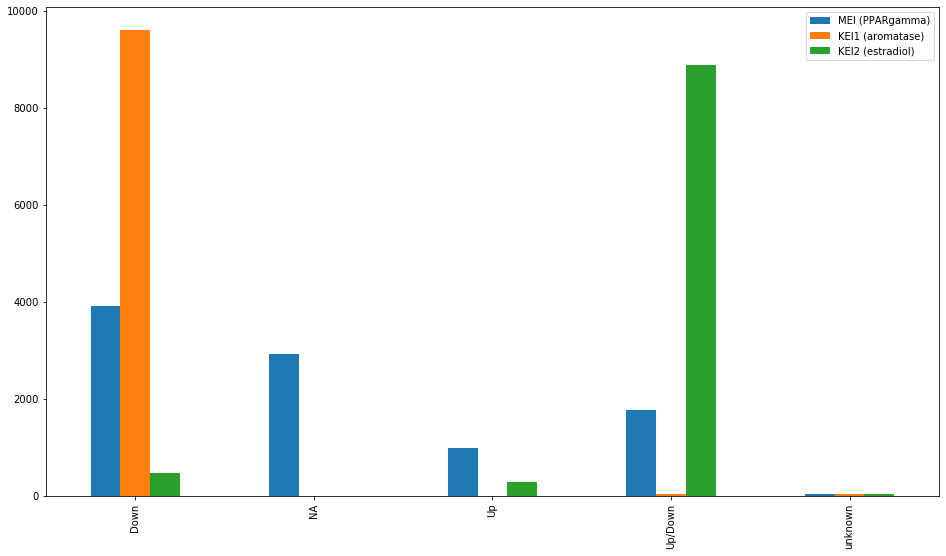

In [15]:
pd.DataFrame({"MEI (PPARgamma)": df["ke1"].value_counts(), "KEI1 (aromatase)": df["ke2"].value_counts(), "KEI2 (estradiol)": df["ke3"].value_counts()}).plot(kind="bar", figsize=(16, 9))